In [1]:
from __future__ import print_function
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

#Libraries used for classifying the images
from fastai.vision.all import *
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from fastai.vision import *

#Libraries used for tumor extraction
import cv2
from google.colab.patches import cv2_imshow

#Libraries used for style transfer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

!cp -r /content/drive/Shareddrives/project546/BRAIN_TUMOR/ ./data

Mounted at /content/drive/


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# This class measures the difference between the content of an input image and an output image, using mean squared error (MSE) loss.
# It calculates the MSE loss between the input image and the output image, and stores it as a class attribute.
# The forward method returns the input image unchanged.
class ContentLoss(nn.Module):
    def __init__(self, output):
        super(ContentLoss, self).__init__()

        # Detach the output image from the computation graph to prevent gradients from flowing through it
        self.output = output.detach()

    def forward(self, input):

        # Calculate the MSE loss between the input image and the output image
        self.loss = F.mse_loss(input, self.output)
        return input

# This class measures the difference between the style of an input image and a output image, using MSE loss.
# It calculates the style loss between the input image and the output image using the Gram matrix of the input and output images,
# and stores it as a class attribute. The forward method returns the input image unchanged.
class StyleLoss(nn.Module):

    def __init__(self, output):
        super(StyleLoss, self).__init__()

        # Detach the output image from the computation graph to prevent gradients from flowing through it
        self.output = self.gram_matrix(output).detach()

    def forward(self, input):

        # Calculate the Gram matrix of the input image
        G = self.gram_matrix(input)

        # Calculate the MSE loss between the input image's Gram matrix and the output image's Gram matrix
        self.loss = F.mse_loss(G, self.output)
        return input

    # This method calculates the Gram matrix of an input image.
    # The Gram matrix is a measure of the correlations between the different channels of an image which captures the style
    def gram_matrix(self, input):

        # Reshape the input image 
        feature_maps = input.view(input.size()[0] * input.size()[1], input.size()[2] * input.size()[3]) 

        # Calculate the Gram matrix by taking the dot product of the reshaped input image matrix with its transpose and normalize it
        return torch.mm(feature_maps, feature_maps.t()) .div(input.size()[0] * input.size()[1] * input.size()[2] * input.size()[3])

# This class normalizes an input image using the given mean and standard deviation.
# The forward method takes an input image, normalizes it using the given mean and standard deviation, and returns the normalized image.
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mu = mean
        self.std = std

    def forward(self, img):

        # Convert the mean and std to tensors with shape (1, 1, C), where C is the number of channels
        self.mu = torch.tensor(self.mu).view(-1, 1, 1)
        self.std=torch.tensor(self.std).view(-1, 1, 1)

        # Normalize the input image by subtracting the mean and dividing by the standard deviation
        return (img - self.mu) / self.std
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,style_img, content_img,content_layers=['conv_4'],style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):

    cnt_losses = []
    sty_losses = []

    #Normalizing
    model = nn.Sequential(Normalization(normalization_mean, normalization_std).to(device))

    i = 0  

    #For each layer, it checks its type and assigns it a name in the format conv_i, relu_i, pool_i, or bn_i
    #depending on whether it is a 2D convolutional layer, ReLU activation layer, max pooling layer, or batch normalization layer, respectively
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            #Incrementing only if the layer is conv
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        model.add_module(name, layer)

        # If the layer is a convolutional or ReLU layer, and its name is present in either the content_layers or style_layers lists, 
        # the function will add a content loss or style loss module to the nn.Sequential model
        if name in content_layers:
            # add content loss:
            content_loss = ContentLoss(model(content_img).detach())
            model.add_module(f"content_loss_{i}", content_loss)
            cnt_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            style_loss = StyleLoss(model(style_img).detach())
            model.add_module(f"style_loss_{i}", style_loss)
            sty_losses.append(style_loss)

    #trims off all layers after the last content or style loss layer
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, sty_losses, cnt_losses

    
def run_style_transfer(cnn, mu, std,content_img, style_img, input_img, num_steps=5,style_weight=1000, cnt_weight=10):

    model, style_losses, cnt_losses = get_style_model_and_losses(cnn,mu, std, style_img, content_img)
    optimizer = optim.LBFGS([input_img])
    
    # Enable gradient computation for the input image
    input_img.requires_grad = True

    # Disable gradient computation for the model as we require the vgg19 model parameters
    model.requires_grad = False

    

    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in cnt_losses:
                content_score += cl.loss

            #Style loss with added weight alpha
            style_score *= style_weight

            #Content loss with added weight alpha
            content_score *= cnt_weight

            loss = 1*style_score +1*content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return 3*style_score + content_score
        # if closure<0.01:
        #   break
        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img


def get_imgs(y,yformat,n,nformat):

  im=[]

  img_path = f"/content/data/yes/Y{y}.{yformat}"
  img_path2 = f"/content/data/no/{n} no.{nformat}"

  # Read in the two images
  image = cv2.imread(img_path)
  image2=cv2.imread(img_path2)

  # Resize and Convert the images to grayscale
  s1=500
  s2=600
  image = cv2.resize(image, (s1, s2))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image2 = cv2.resize(image2, (s1, s2))
  image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)


  # Make a copy of the first image and apply a binary threshold to it
  selection=image.copy()
  (T, thresh) = cv2.threshold(image, 160, 240, cv2.THRESH_BINARY)
  (T, threshInv) = cv2.threshold(image, 155, 255,cv2.THRESH_BINARY_INV)
  cv2_imshow(thresh)
  # Apply morphological closing and erosion and dilation to the thresholded image
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 7))
  style_img = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
  cv2_imshow(style_img)
  style_img = cv2.erode(style_img, None, iterations = 7)
  cv2_imshow(style_img)
  style_img = cv2.dilate(style_img, None, iterations = 11)
  cv2_imshow(style_img)


  # Apply the Canny edge detection algorithm to the original image
  v = np.median(style_img)
  edged = cv2.Canny(image, int(max(0, (1.0 - 0.33) * v)), int(min(255, (1.0 + 0.33) * v)))

  # Draw the contours found on the original image
  cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
  cv2.CHAIN_APPROX_SIMPLE)
  cv2.drawContours(image, cnts, -1, (0, 0, 255), 2)
  im.append(image)

  # Replace all pixels with the value 240 in the thresholded image with the corresponding pixel value from the original image
  for i in range(len(style_img)):
    for j in range(len(style_img[0])):
      if style_img[i,j]==240:
        style_img[i,j]=selection[i,j]

  return image2,style_img

def image_loader(loader,image_name):
    image_name=Image.fromarray(image_name)
    image = loader(image_name).unsqueeze(0) 
    return image.to(device, torch.float)

def main():

  # scale and transform it into a torch tensor
  loader = transforms.Compose([transforms.Resize(512),transforms.ToTensor()])

  #Call the get_imgs to get content image and style  
  content_img,style_img=get_imgs(58,'JPG',2,'jpeg')

  ct=content_img.copy()
  st=style_img.copy()
  #Convert the type of images for training
  style_img= image_loader(loader,style_img)
  content_img= image_loader(loader,content_img)

  #VGG19
  cnn = models.vgg19(pretrained=True).features.to(device).eval()

  #Normalizing the model
  cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
  cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
  normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
  model = nn.Sequential(normalization)

  #Sendding the initialization image as style image
  input_img = style_img.clone()

  #Training style transfer
  output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                              content_img, style_img, input_img,150,1000,1)
  ou=output.cpu().detach().numpy().reshape((-1,512))
  cv2_imshow(ou*255)
  cv2_imshow(ct)
  cv2_imshow(st)
  return ou*255


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.172587,1.282861,0.490196,0.509804,00:05


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.712191,1.225223,0.568627,0.431373,00:02
1,1.660250,0.992442,0.431373,0.568627,00:01
2,1.510305,0.716969,0.274510,0.725490,00:01
3,1.351644,0.580707,0.196078,0.803922,00:01
4,1.251546,0.573168,0.196078,0.803922,00:02
5,1.129213,0.736887,0.196078,0.803922,00:02
6,1.027294,0.719840,0.156863,0.843137,00:01
7,0.937443,0.652789,0.098039,0.901961,00:01
8,0.854228,0.710318,0.098039,0.901961,00:01
9,0.787657,0.761398,0.098039,0.901961,00:01


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.182483,0.423086,0.078431,0.921569,00:01


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.197512,0.397588,0.078431,0.921569,00:01
1,0.186929,0.390857,0.078431,0.921569,00:01
2,0.174188,0.380831,0.078431,0.921569,00:01
3,0.191335,0.371823,0.117647,0.882353,00:01
4,0.187589,0.376209,0.117647,0.882353,00:01
5,0.177168,0.388052,0.098039,0.901961,00:01
6,0.176224,0.405310,0.098039,0.901961,00:01
7,0.174520,0.417303,0.117647,0.882353,00:01
8,0.170124,0.427676,0.117647,0.882353,00:02
9,0.171689,0.430074,0.117647,0.882353,00:02


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.194538,0.462454,0.117647,0.882353,00:01
1,0.257465,0.463706,0.117647,0.882353,00:01
2,0.222291,0.461988,0.117647,0.882353,00:01
3,0.214033,0.452604,0.117647,0.882353,00:01
4,0.199834,0.451884,0.117647,0.882353,00:01
5,0.182657,0.444266,0.098039,0.901961,00:01


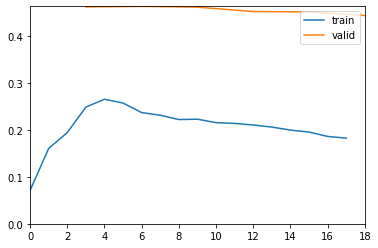

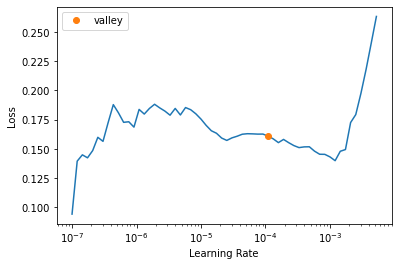

In [5]:

fields = DataBlock(blocks=(ImageBlock, CategoryBlock),
   get_items=get_image_files,
   get_y=parent_label,
   splitter=RandomSplitter(valid_pct=0.2, seed=42),
   item_tfms=RandomResizedCrop(224, min_scale=0.5),
   batch_tfms=aug_transforms())
dls=fields.dataloaders('/content/data')
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy], model_dir="/tmp/model/").to_fp16()
learn.fine_tune(15)
learn.lr_find()
learn.fine_tune(15, base_lr=1e-7)
learn.fit_one_cycle(6, slice(1e-7),cbs=[ShowGraphCallback()])

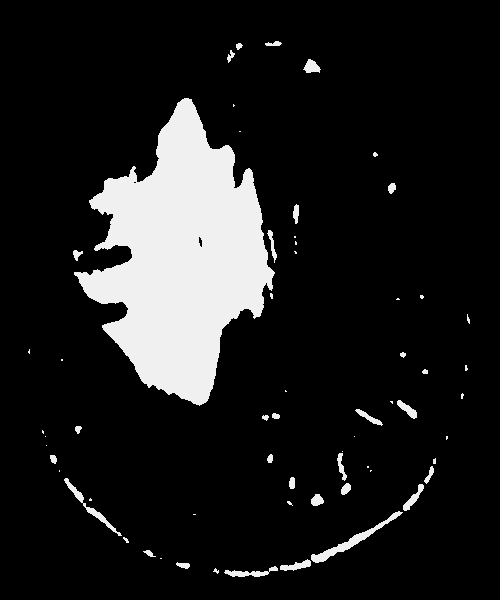

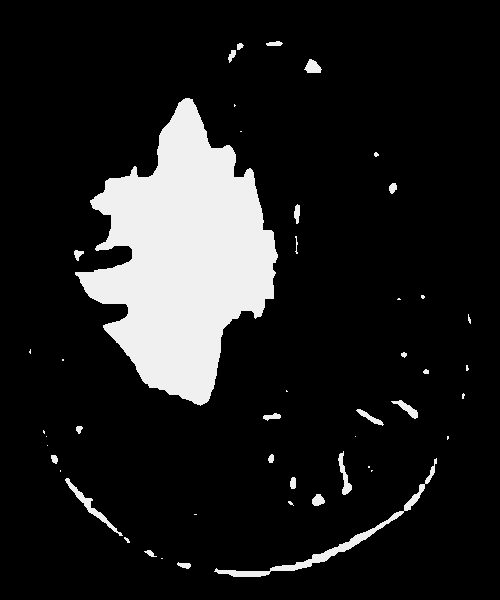

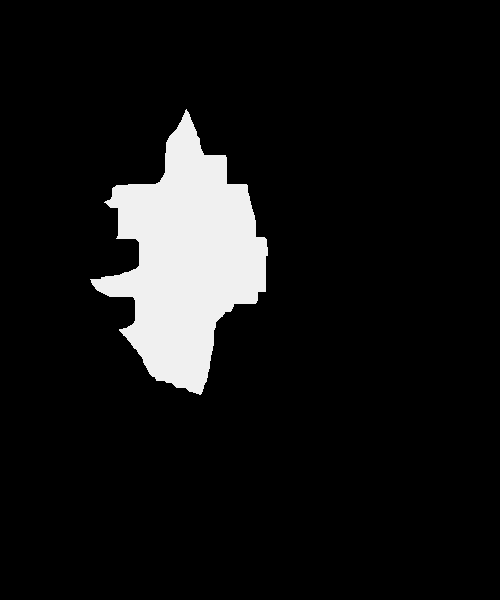

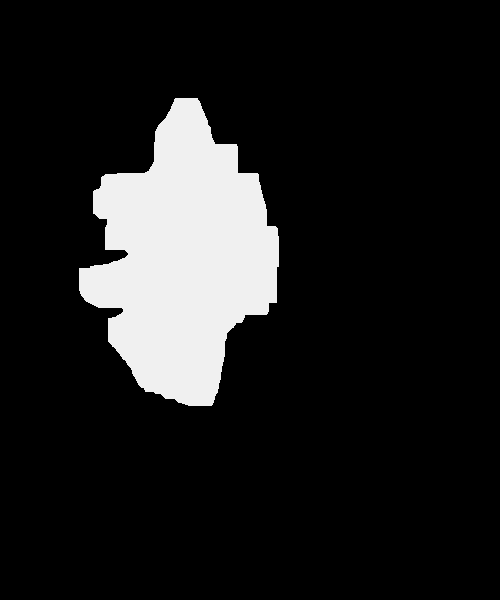

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

<ipython-input-3-3c29cf73eebe>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mu = torch.tensor(self.mu).view(-1, 1, 1)
<ipython-input-3-3c29cf73eebe>:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std=torch.tensor(self.std).view(-1, 1, 1)


run [50]:
Style Loss : 0.392519 Content Loss: 0.963825

run [100]:
Style Loss : 0.410723 Content Loss: 0.605348

run [150]:
Style Loss : 0.491812 Content Loss: 0.533840



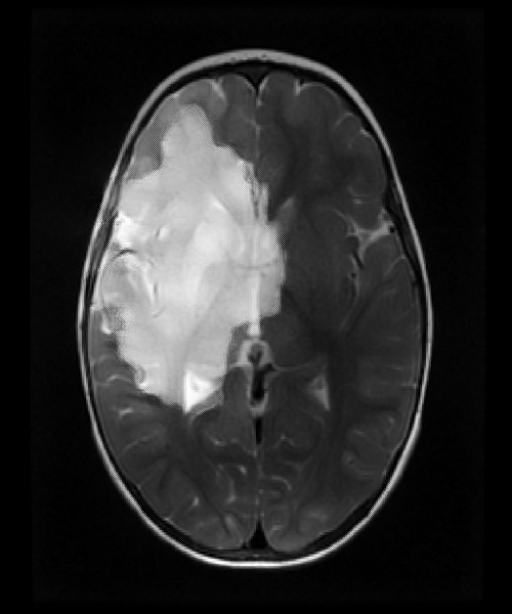

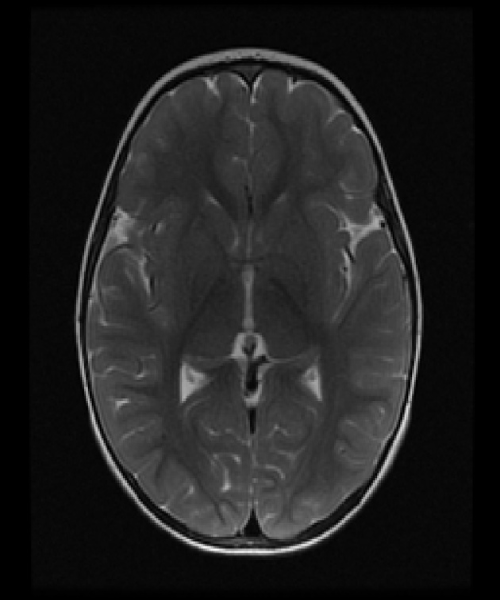

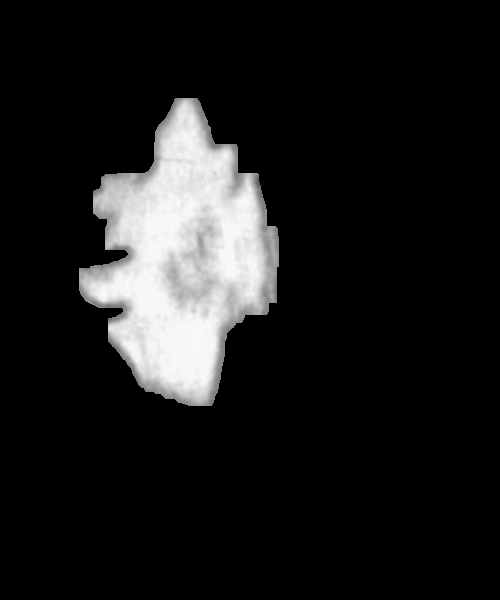

Predicted class:  yes


In [6]:
if __name__=="__main__":
  #Go to the get_imgs() function in main() and change the images for style and content if necessary
  #We have used Y58.JPG and 2 no.jpeg for style and content
  image=main()
  prediction = learn.predict(image)
  print("Predicted class: ", prediction[0])